In [1]:
%cd ..

c:\Users\s2558406\Documents\Repos\cmr-experiments


c:\Users\s2558406\Documents\Repos\cmr-experiments\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from utils.edipo.data.transforms import CineNetDataTransform
from utils.edipo.data.mri_data import RawDataSample
from utils.edipo.models.crnn import CRNN
from utils import *
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

In [6]:
# ONLY RUN when new dataset_cache run on Linux
import pathlib, pickle
with open("dataset_cache.pkl", "rb") as f:
    with set_posix_windows():
        dataset_cache = pickle.load(f)
    
    new_cache = {
        pathlib.WindowsPath(r"M:\data\CMRxRecon\SingleCoil\Cine\TrainingSet"):
    [
        RawDataSample(r.fname.replace("/home/s2558406/RDS", "M:").replace("/", "\\"), r.slice_ind, r.metadata) for r in dataset_cache[
            pathlib.WindowsPath('/home/s2558406/RDS/data/CMRxRecon/SingleCoil/Cine/TrainingSet')
        ]
    ]}

with open("dataset_cache_windows.pkl", "wb") as f:
    pickle.dump(new_cache, f)
    

In [3]:
dataset = DeepinvSliceDataset(
    Path(r"M:\data\CMRxRecon"), 
    transform=CineNetDataTransform(time_window=12, apply_mask=True, normalize=False), 
    set_name="TrainingSet",
    acc_folders=["FullSample"],
    mask_folder="TimeVaryingGaussianMask16",#"AccFactor08",
    dataset_cache_file="dataset_cache_windows.pkl"
    )

Using dataset cache file


In [4]:
train_dataset, test_dataset = random_split(dataset, (0.8, 0.2))

In [5]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(dataset= test_dataset, batch_size=1, shuffle=False)

In [6]:
x, y, mask = next(iter(train_dataloader))

In [7]:
physics = DynamicMRI((1, 2, 12, 512, 256))
y2 = physics(x, mask=mask)

In [8]:
x_hat = physics.A_adjoint(y2, mask=mask)

In [9]:
model = ArtifactRemovalCRNN(
    CRNN(num_cascades=2)
).to("cpu")

In [10]:
physics.set_mask(mask)
x_recon = model(y, physics)

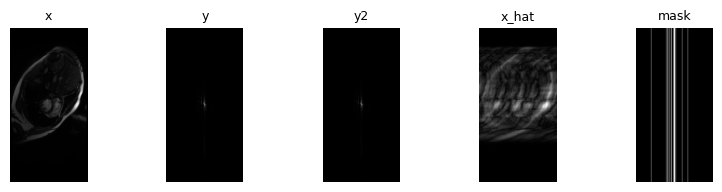

In [9]:
plot_gif([x, y, y2, x_hat, mask], titles=["x", "y", "y2", "x_hat", "mask"], display=True)

In [15]:
import deepinv as dinv

In [16]:
class Undersampling(dinv.physics.DecomposablePhysics):
    def __init__(self, mask, device="cpu", **kwargs):
        super().__init__(**kwargs)
        self.mask = torch.nn.Parameter(mask.to(device), requires_grad=False)

In [22]:
loss = YamanSplittingLoss(split_ratio=0.9)

mask2 = loss.subsample_mask(loss.rng, physics.mask.data.detach().clone())

inp = Undersampling(mask2, device=y.device)

inp2 = Undersampling(mask - mask2, device=y.device)

physics1 = DynamicMRI(physics.img_size)
physics1.set_mask(mask2)
physics2 = DynamicMRI(physics.img_size)
physics2.set_mask(mask - mask2)

# divide measurements
y1 = inp.A(y)
y2 = inp2.A(y)

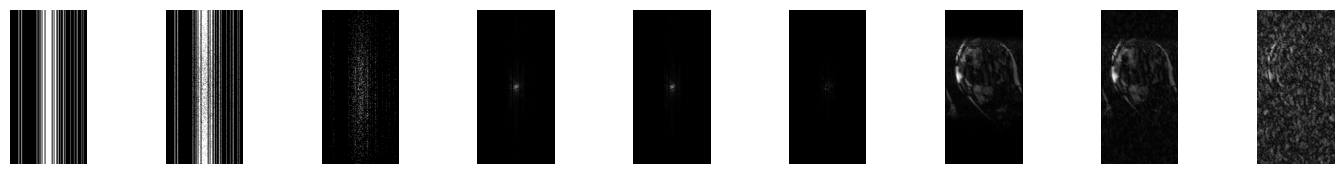

In [23]:
plot_videos([
    mask, mask2, mask-mask2, 
    y, y1, y2, 
    physics.A_adjoint(y, mask=mask), physics1.A_adjoint(y1, mask=mask2), physics2.A_adjoint(y2, mask=mask-mask2)
], display=True)